Use GPU if available

In [1]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
    )

print(f"Using {device} device")

Using cuda device


Load CIFAR10 dataset

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor()]
    )

trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
    )

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True, # reshuffle data at every epoch
    num_workers=2
    )

testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
    )

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
    )

classes = ("plane", "car", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:12<00:00, 13985948.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Define the neural network

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, stride=1, padding=2)
        self.batchNorm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 64, 5, stride=1, padding=2)
        self.batchNorm2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 64, 5, stride=1, padding=2)
        self.batchNorm3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(4 * 4 * 64, 500)
        self.batchNorm4 = nn.BatchNorm1d(500)
        
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv2(x)
        x = self.batchNorm2(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = self.conv3(x)
        x = self.batchNorm3(x) # batch normalization
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = self.fc1(x)
        x = self.batchNorm4(x) # batch normalization
        x = F.relu(x)
        
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)

        return x


Define optimizer

In [4]:
import torch.optim as optim
import torch.nn as nn

torch.manual_seed(1)
model = Net()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.0) # mini batch gradient descent

Train the neural network

epoch: 0, total loss: 669.3903886675835
epoch: 1, total loss: 479.6290104985237
epoch: 2, total loss: 398.86033111810684
epoch: 3, total loss: 349.7273857295513
epoch: 4, total loss: 308.5810495913029
epoch: 5, total loss: 273.32395058870316
epoch: 6, total loss: 242.14337772130966
epoch: 7, total loss: 217.7577315568924
epoch: 8, total loss: 188.0654122531414
epoch: 9, total loss: 167.13615195453167
epoch: 10, total loss: 148.0927651822567
epoch: 11, total loss: 129.5841914191842
epoch: 12, total loss: 115.48787507414818
epoch: 13, total loss: 98.35575430840254
epoch: 14, total loss: 89.00053911656141
epoch: 15, total loss: 76.68456774950027
epoch: 16, total loss: 70.90828702971339
epoch: 17, total loss: 63.191174279898405
epoch: 18, total loss: 55.61861220933497
epoch: 19, total loss: 49.65797164104879
epoch: 20, total loss: 43.863216642290354
epoch: 21, total loss: 39.777682814747095
epoch: 22, total loss: 35.97696002572775
epoch: 23, total loss: 33.19807059597224
epoch: 24, total l

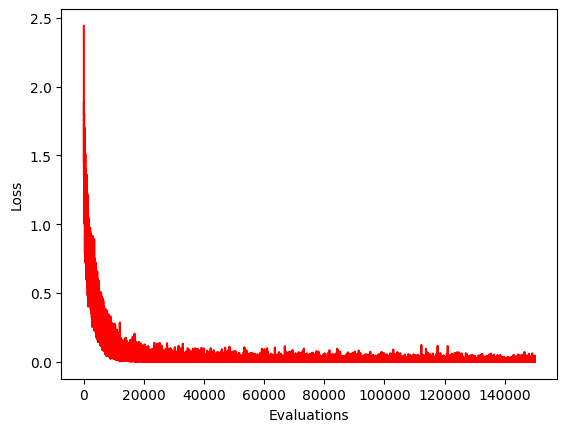

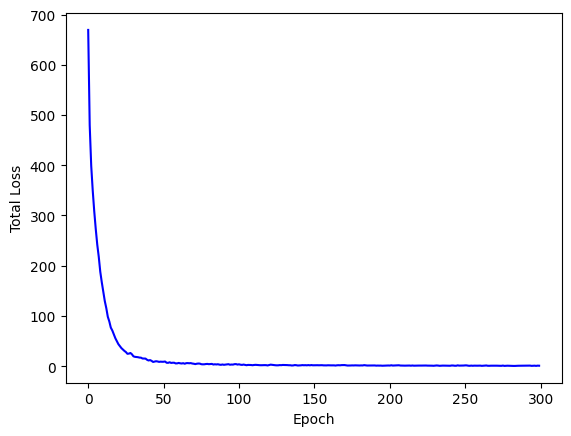

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import time

total_loss_list = []
loss_list = []

start = time.perf_counter()

for epoch in range(300):  # loop over the dataset multiple times

  total_loss = 0

  # on each mini-batch, the model uses the same weigths for that current
  # mini-batch, hence, the number of times the model weights will be updated
  # is given by total_trainset / mini_batch_size

  # loop over the dataset and get mini-batch
  for mini_batch_num, data in enumerate(trainloader, 0):
    images = data[0].to(device)
    labels = data[1].to(device)

    optimizer.zero_grad() # zero the parameter gradients

    preds = model(images) # forward mini-batch
    loss = F.cross_entropy(preds, labels) # calculate loss of all the mini-batch
    
    loss_list.append(loss.item()) # track the loss
    
    loss.backward() # calculate gradients with respect to each weight
    optimizer.step() # update weights
    
    total_loss += loss.item()

  print(f"epoch: {epoch}, total loss: {total_loss}")
  total_loss_list.append(total_loss)

end = time.perf_counter()

print(f"Finished training, time taken {start-end} seconds")

# plot the loss rate
plt.plot(np.array(loss_list), 'r')
plt.ylabel("Loss")
plt.xlabel("Evaluations")
plt.show()
plt.plot(np.array(total_loss_list), 'b')
plt.ylabel("Total Loss")
plt.xlabel("Epoch")
plt.show()

Test the neural network

In [6]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")

Accuracy of the network on the 10000 test images: 77 %


Save the model

In [7]:
PATH = "../nn-models/cifar_model_300epoch_77acc.pth"
torch.save(model.state_dict(), PATH)

Load the model

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

Freeze all the weights except for the last layer

In [ ]:
# Freeze all the parameters in the network
for param in model.parameters():
  param.requires_grad = False

# Unfreeze all the parameters from the last layer
for param in model.fc2.parameters():
  param.requires_grad = True

In [ ]:
import operator
import random
import numpy
import math
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

# all the parameters from the last layer will be the decision variables
# the fitness will be the loss function, i.e. cross entropy
# a particle will contain:
## current solution (parameters)
## current fitness value
## best solution (personal best)
## best solution of the entire population (global best)

dimension = len(model.fc2.parameters())
generations = 100

population_size = 50
c1 = 2.0
c2 = 2.0

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle",
               list,
               fitness=creator.FitnessMin,
               velocity=list,
               vmin=None,
               vmax=None,
               personal_best=None)

# create a random population of particles

# loop over g generations

## loop over every particle
### evaluate fitness value
### check if the fitness value is better than personal best

## set the best of the personal best as the global best

## update the particles velocity -> v(t+1) =
# w*v(t)
# + c1*r1(t) (pbest - x(t))
# + c2*r2(t) (gbest - x(t))

# w -> inertia decaying weight
# c1 and c2 -> constants
# r1(t) and r2(t) -> uniformly distributed random number between [0,1]
#                    each time instant, for each particle, and for each
#                    dimension
# pbest -> personal best solution of the current particle (n-dimensional vector)
# gbest -> global best solution (n-dimensional vector)
# n -> number of decision variables (parameters)

## update the particles positions (parameters)
